## Import necessary modules
Run this cell before running any other cells

In [10]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

from matplotlib import pyplot as plt
import random
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Printing and Logging
## Printing
You can use the **print()** function in Python to print messages to the screen. <br>
The message can be a string, or any other object, the object will be converted into a string before it is written to the screen. <br>

## Logging
You could use the logging module that is setup in *utils.py*. <br>
It prints to both your screen (standard output) as well as to log files (*ble.log*) in the *logs* directory. <br>
This is the recommended way to output messages, since the log files can help with debugging. <br>
The logging module also provides different log levels as shown below, each formatted with a different color for increased visibility. <br>

__**NOTE**__: You may notice that the DEBUG message is not printed to the screen but is printed in the log file. This is because the logging level for the screen is set to INFO and for the file is set to DEBUG. You can change the default log levels in *utils.py* (**STREAM_LOG_LEVEL** and **FILE_LOG_LEVEL**). 

## Formatting output
To format your strings, you may use %-formatting, str.format() or f-strings. <br>
The most "pythonic" way would be to use f-strings. [Here](https://realpython.com/python-f-strings/) is a good tutorial on f-strings. <br>

In [11]:
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

2023-04-03 23:48:54,852 | INFO     |: info
2023-04-03 23:48:54,858 | WARNING  |: warning
2023-04-03 23:48:54,869 | ERROR    |: error
2023-04-03 23:48:54,874 | CRITICAL |: critical


<hr>

# BLE
## ArtemisBLEController
The class **ArtemisBLEController** (defined in *ble.py*) provides member functions to handle various BLE operations to send and receive data to/from the Artemis board, provided the accompanying Arduino sketch is running on the Artemis board. <br>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Functions</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">reload_config()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Reload changes made in <em>connection.yaml.</em></span></th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">connect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Connect to the Artemis board, whose MAC address is specified in <em>connection.yaml</em>.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">disconnect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Disconnect from the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">is_connected()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Return a boolean indicating whether your controller is connected to the Artemis board or not.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">send_command(cmd_type, data)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Send the command <strong>cmd_type</strong> (integer) with <strong>data</strong> (string) to the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">receive_float(uuid) <br> receive_string(uuid) <br> receive_int(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Read the GATT characteristic (specified by its <strong>uuid</strong>) of type float, string or int. <br> The type of the GATT
            characteristic is determined by the classes BLEFloatCharacteristic, BLECStringCharacteristic or
            BLEIntCharacteristic in the Arduino sketch.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">start_notify(uuid, notification_handler)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Activate notifications on the GATT characteristic (specified by its <strong>uuid</strong>). <br> <strong>notification_handler</strong> is a
            function callback which must accept two inputs; the first will be a uuid string object and the second will
            be the bytearray of the characteristic value.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">bytearray_to_float(byte_array) <br> bytearray_to_string(byte_array) <br> bytearray_to_int(byte_array)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Convert the <strong>bytearray</strong> to float, string or int, respectively. <br> You may use these functions inside your
            notification callback function.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">stop_notify(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Stop notifications on the GATT characteristic (specified by its <strong>uuid</strong>).</span></th>
    </tr>
</table>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Variables</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">uuid</span></th>
        <th style="text-align: left"><span style="font-weight: normal">A dictionary that stores the UUIDs of the various characteristics specified in <em>connection.yaml</em>.</span></th>
    </tr>
</table>

## Configuration
- The MAC address, Service UUID and GATT characteristic UUIDs are defined in the file: *connection.yaml*.
- They should match the UUIDs used in the Arduino sketch.
- The artemis board running the base code should display its MAC address in the serial monitor.
- Update the **artemis_address** in *connection.yaml*, accordingly.
- Make sure to call **ble.reload_config()** or **get_ble_controller()** (which internally calls **reload_config()**) after making any changes to your configuration file.

<hr>

In the below cell, we create an **ArtemisBLEController** object using **get_ble_controller()** (defined in *ble.py*), which creates and/or returns a single instance of **ArtemisBLEController**. <br>
<span style="color:rgb(240,50,50)"> __NOTE__: Do not use the class directly to instantiate an object. </span><br>

In [12]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-04-03 23:48:57,961 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:83:D5:66:86:3C


Exception: Could not find device with address: C0:83:D5:66:86:3C and service uuid: 5d8a3150-8994-4b11-8ea4-d06dfd5e65bd

## Receive data from the Artemis board

The cell below shows examples of reading different types (as defined in the Arduino sketch) of GATT characteristics.

In [155]:
# Read a float GATT Charactersistic
f = ble.receive_float(ble.uuid['RX_FLOAT'])
print(f)

5.0


In [156]:
# Read a string GATT Charactersistic
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

[->9.0<-]


## Send a command to the Artemis board
Send the PING command and read the reply string from the string characteristic RX_STRING. <br>
__NOTE__: The **send_command()** essentially sends a string data to the GATT characteristic (TX_CMD_STRING). The GATT characteristic in the Arduino sketch is of type BLECStringCharacteristic.

In [157]:
ble.send_command(CMD.PING, "")

2023-02-16 04:25:47,872 | INFO     |: Disconnected from AB6C95E9-A4ED-4F7A-B208-0AFEAFDDA3AD
2023-02-16 04:25:47,872 | INFO     |: Disconnected from AB6C95E9-A4ED-4F7A-B208-0AFEAFDDA3AD


In [89]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

[->9.0<-]


The cell below shows an example of the SEND_TWO_INTS command. <br> The two values in the **data** are separated by a delimiter "|". <br>
Refer Lab 2 documentation for more information on the command protocol.

In [151]:
ble.send_command(CMD.SEND_TWO_INTS, "2|-6")

The Artemis board should print the two integers to the serial monitor in the ArduinoIDE. 

## Disconnect

In [139]:
# Disconnect
ble.disconnect()

Exception: Not connected to a BLE device

In [3]:
from uuid import uuid4
uuid4()

UUID('5d8a3150-8994-4b11-8ea4-d06dfd5e65bd')

In [12]:
# Document sensor range, accuracy, repeatability, and ranging time
def tof_callback(uuid, data):
    global instances
    global location
    global timeAtLocationDark
    global distanceAtLocationDark
    
    pair = (ble.bytearray_to_string(data)).split('|')
    
    distanceAtLocationDark[location][instances] = pair[0]
    timeAtLocationDark[location][instances] = pair[1]
    
    if (instances == 49):

        print(len(distanceAtLocationDark))
        print(distanceAtLocationDark[location])
        print(len(timeAtLocationDark))
        print(timeAtLocationDark[location])
        location += 1
        instances = 0
    else:
        instances += 1

timeAtLocationDark =  np.ones((14,50))
distanceAtLocationDark = np.ones((14,50))
location = 0
instances = 0
ble.start_notify(ble.uuid['RX_STRING'], tof_callback)
ble.send_command(CMD.TEST_TOF, "")

14
[442.   0. 444.   0. 441.   0. 446.   0. 442.   0. 445.   0. 442.   0.
 441.   0. 443.   0. 444.   0. 440.   0. 440.   0. 442.   0. 441.   0.
 443.   0. 444.   0. 442.   0. 443.   0. 442.   0. 443.   0. 440.   0.
 440.   0. 443.   0. 441.   0. 444.   0.]
14
[70. 25. 53. 32. 53. 35. 54. 31. 53. 32. 52. 33. 53. 35. 55. 35. 53. 34.
 52. 31. 54. 34. 53. 35. 55. 32. 52. 36. 55. 34. 52. 36. 53. 35. 53. 34.
 52. 32. 53. 33. 54. 35. 55. 35. 52. 33. 54. 34. 54. 33.]
14
[ 440.    0.  443.    0.  441.    0.  445.    0.  445.    0.  443.    0.
  442.    0.  442.    0.  444.    0.  442.    0.  444.    0.  444.    0.
  444.    0.  443.    0.  443. 2434.  444.    0.  445.    0.  443. 2420.
  444.    0.  444.    0.  444.    0.  440.    0.  444.    0.  443.    0.
  442.    0.]
14
[52. 33. 52. 31. 52. 33. 53. 34. 54. 39. 54. 38. 55. 34. 54. 34. 53. 31.
 54. 32. 52. 33. 53. 34. 52. 33. 54. 33. 54. 35. 52. 34. 55. 33. 55. 34.
 57. 34. 53. 33. 52. 31. 55. 32. 53. 33. 52. 34. 54. 37.]
2023-02-16 05:04:42

In [97]:
ble.stop_notify(ble.uuid['RX_STRING'])

Exception: Not connected to a BLE device

[50, 200, 350, 500, 650, 800, 950, 1100, 1250, 1400, 1550, 1700, 1850, 2000]
[[  55.   54.   55.   52.   53.   55.   56.   54.   53.   54.   53.   54.
    54.   56.   55.   55.   56.   53.   55.   53.   55.   52.   55.   54.
    54.   54.   52.   57.   56.   55.   55.   53.   53.   53.   51.   55.
    54.   54.   54.   54.   54.   53.   55.   54.   53.   56.   55.   54.
    55.   54.]
 [ 212.  213.  213.  215.  213.  215.  213.  214.  214.  213.  213.  212.
   212.  213.  213.  214.  213.  213.  213.  213.  212.  212.  214.  212.
   214.  213.  215.  213.  214.  212.  215.  214.  214.  212.  213.  212.
   213.  213.  213.  213.  212.  212.  213.  214.  214.  210.  212.  212.
   212.  213.]
 [ 366.  365.  366.  366.  366.  366.  364.  366.  365.  365.  366.  366.
   367.  366.  366.  366.  367.  368.  365.  366.  366.  366.  365.  366.
   365.  367.  366.  364.  366.  363.  366.  365.  365.  365.  366.  366.
   366.  365.  364.  366.  366.  365.  366.  365.  366.  366.  364.  365.
   36

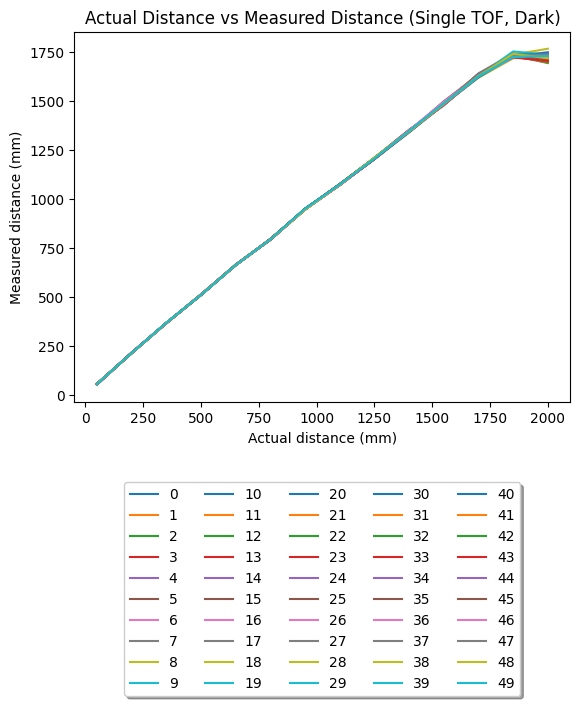

In [100]:
# Plot distance measurement data
actual = []
for i in range(50, 2150, 150):
    actual.append(i)
    
print(actual)
print(distanceAtLocationDark)

for set in range(50):
    plt.plot(actual, distanceAtLocationDark[:,set], label = str(set))

plt.title("Actual Distance vs Measured Distance (Single TOF, Dark)")
plt.xlabel("Actual distance (mm)")
plt.ylabel("Measured distance (mm)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)


In [66]:
print(actual)
%store distanceAtLocation
%store timeAtLocation


[50, 200, 350, 500, 650, 800, 950, 1100, 1250, 1400, 1550, 1700, 1850, 2000]
Stored 'distanceAtLocation' (ndarray)
Stored 'timeAtLocation' (ndarray)


In [101]:
%store distanceAtLocationDark
%store timeAtLocationDark

Stored 'distanceAtLocationDark' (ndarray)
Stored 'timeAtLocationDark' (ndarray)


In [102]:
%store actual

Stored 'actual' (list)


In [64]:
test = [[  70.   70.   68.   69.   66.   69.   69.   69.   71.   68.   68.   70.
    71.   69.   69.   69.   69.   67.   69.   70.   69.   69.   69.   68.
    68.   70.   68.   70.   69.   70.   68.   68.   69.   69.   68.   67.
    68.   69.   68.   67.   66.   71.   69.   69.   67.   68.   67.   67.
    68.   68.]
 [ 223.  224.  224.  222.  224.  222.  222.  224.  221.  223.  223.  223.
   223.  223.  223.  222.  223.  222.  224.  222.  223.  223.  222.  223.
   222.  222.  222.  223.  222.  221.  219.  223.  222.  226.  223.  223.
   221.  224.  223.  222.  223.  222.  224.  225.  222.  222.  222.  223.
   222.  222.]
 [ 374.  374.  373.  374.  374.  372.  375.  374.  375.  373.  374.  376.
   372.  373.  374.  372.  374.  374.  371.  375.  373.  374.  372.  375.
   374.  373.  374.  375.  373.  372.  374.  374.  372.  374.  375.  374.
   374.  373.  373.  372.  373.  373.  373.  374.  375.  373.  374.  373.
   374.  373.]
 [ 526.  528.  528.  528.  528.  526.  529.  529.  526.  527.  527.  529.
   528.  527.  526.  528.  528.  528.  529.  526.  527.  527.  528.  525.
   526.  525.  526.  527.  529.  526.  528.  526.  528.  528.  526.  527.
   527.  526.  528.  526.  528.  527.  529.  528.  529.  527.  526.  527.
   528.  529.]
 [ 675.  674.  674.  674.  677.  673.  673.  673.  674.  675.  674.  675.
   673.  673.  675.  674.  675.  674.  673.  673.  672.  674.  673.  675.
   675.  673.  674.  677.  674.  677.  673.  672.  675.  674.  675.  675.
   675.  674.  675.  673.  677.  674.  676.  675.  675.  677.  675.  673.
   672.  675.]
 [ 835.  839.  838.  837.  835.  835.  837.  839.  837.  837.  838.  838.
   839.  835.  837.  836.  835.  833.  838.  839.  837.  836.  839.  834.
   835.  835.  839.  839.  839.  838.  836.  836.  839.  835.  837.  835.
   838.  836.  838.  835.  839.  840.  834.  838.  837.  838.  838.  836.
   836.  837.]
 [ 995.  990.  994.  995.  995.  994.  994.  993.  993.  994.  993.  994.
   993.  995.  994.  995.  994.  994.  991.  992.  989.  992.  995.  993.
   993.  994.  991.  993.  992.  996.  993.  995.  995.  990.  992.  989.
   996.  993.  992.  989.  993.  996.  998.  997.  991.  994.  993.  995.
   994.  997.]
 [1113. 1121. 1111. 1119. 1116. 1112. 1114. 1109. 1112. 1109. 1113. 1117.
  1109. 1113. 1115. 1117. 1112. 1115. 1115. 1113. 1114. 1112. 1108. 1115.
  1103. 1117. 1115. 1110. 1116. 1111. 1115. 1113. 1109. 1110. 1112. 1110.
  1110. 1111. 1112. 1116. 1114. 1116. 1110. 1110. 1115. 1107. 1114. 1110.
  1112. 1109.]
 [1240. 1236. 1242. 1239. 1239. 1234. 1246. 1240. 1240. 1235. 1237. 1237.
  1243. 1240. 1238. 1237. 1246. 1240. 1245. 1241. 1244. 1235. 1240. 1238.
  1239. 1240. 1240. 1245. 1238. 1240. 1236. 1234. 1242. 1246. 1236. 1239.
  1243. 1239. 1240. 1235. 1235. 1231. 1241. 1237. 1237. 1239. 1243. 1233.
  1236. 1241.]
 [1350. 1363. 1357. 1353. 1359. 1366. 1359. 1360. 1356. 1360. 1364. 1367.
  1370. 1362. 1364. 1359. 1370. 1363. 1371. 1352. 1366. 1368. 1361. 1362.
  1363. 1365. 1366. 1359. 1361. 1359. 1364. 1353. 1352. 1364. 1360. 1365.
  1361. 1364. 1366. 1363. 1358. 1365. 1359. 1364. 1369. 1363. 1353. 1357.
  1357. 1372.]
 [1473. 1483. 1482. 1503. 1510. 1496. 1500. 1492. 1491. 1487. 1494. 1494.
  1490. 1492. 1496. 1482. 1512. 1487. 1500. 1489. 1483. 1481. 1484. 1507.
  1503. 1501. 1495. 1515. 1489. 1494. 1478. 1493. 1502. 1488. 1485. 1491.
  1478. 1496. 1477. 1487. 1491. 1485. 1484. 1477. 1492. 1490. 1497. 1487.
  1473. 1487.]
 [1585. 1604. 1583. 1579. 1581. 1609. 1584. 1605. 1565. 1589. 1604. 1609.
  1562. 1540. 1601. 1601. 1597. 1612. 1593. 1580. 1602. 1585. 1603. 1580.
  1620. 1581. 1614. 1586. 1617. 1594. 1614. 1599. 1587. 1587. 1590. 1592.
  1576. 1605. 1620. 1607. 1596. 1589. 1612. 1594. 1619. 1606. 1595. 1592.
  1595. 1584.]
 [1641. 1642. 1654. 1665. 1709. 1668. 1682. 1677. 1702. 1650. 1684. 1711.
  1687. 1687. 1700. 1688. 1678. 1643. 1734. 1695. 1700. 1700. 1676. 1676.
  1721. 1677. 1673. 1688. 1718. 1697. 1685. 1679. 1691. 1706. 1707. 1681.
  1680. 1698. 1649. 1662. 1657. 1683. 1674. 1667. 1676. 1659. 1623. 1700.
  1667. 1650.]
 [1962. 1967. 1975. 1992. 1991. 1992. 1975. 1974. 1981. 1976. 1988. 1969.
  1977. 1987. 1963. 1992. 1982. 1974. 1971. 1971. 1979. 1971. 1957. 1979.
  1989. 1979. 1970. 1966. 1979. 1979. 1977. 1978. 1975. 1967. 1989. 1965.
  1983. 1975. 1968. 1973. 1983. 1967. 1965. 1991. 1990. 1978. 1975. 1993.
  1985. 1982.]]


SyntaxError: invalid syntax (2529098759.py, line 1)

In [ ]:
# Document sensor range, accuracy, repeatability, and ranging time. in LIGHT
def tof_callback(uuid, data):
    global instances
    global location
    global timeAtLocationDark
    global distanceAtLocationDark
    
    pair = (ble.bytearray_to_string(data)).split('|')
    
    distanceAtLocationDark[location][instances] = pair[0]
    timeAtLocationDark[location][instances] = pair[1]
    timeAtLocationDark[location][instances] = pair[2]
    
    if (instances == 49):

        print(len(distanceAtLocationDark))
        print(distanceAtLocationDark[location])
        print(len(timeAtLocationDark))
        print(timeAtLocationDark[location])
        location += 1
        instances = 0
    else:
        instances += 1

timeAtLocationDark =  np.ones((14,50))
distanceAtLocationDark = np.ones((14,50))
location = 0
instances = 0
ble.start_notify(ble.uuid['RX_STRING'], tof_callback)
ble.send_command(CMD.TEST_TOF, "")

In [124]:
# Document sensor range, accuracy, repeatability, and ranging time for 2 TOFS.
def double_tof_callback(uuid, data):
    global ONEinstances
    global TWOinstances
    global location
    global ONEtimeAtLocation
    global ONEdistanceAtLocation
    global TWOtimeAtLocation
    global TWOdistanceAtLocation
    
    pair = (ble.bytearray_to_string(data)).split('|')
    
    if pair[2] == "1":
        ONEdistanceAtLocation[location][ONEinstances] = pair[0]
        ONEtimeAtLocation[location][ONEinstances] = pair[1]
    else:
        TWOdistanceAtLocation[location][TWOinstances] = pair[0]
        TWOtimeAtLocation[location][TWOinstances] = pair[1]
    
    if (ONEinstances == 50 and TWOinstances == 49):

        print(len(ONEdistanceAtLocation))
        print(ONEdistanceAtLocation[location])
        print(len(TWOdistanceAtLocation))
        print(TWOdistanceAtLocation[location])
        location += 1
        ONEinstances = 0
        TWOinstances = 0
    else:
        if pair[2] == "1":
            ONEinstances += 1
        else:
            TWOinstances += 1

ONEtimeAtLocation =  np.ones((14,50))
ONEdistanceAtLocation = np.ones((14,50))
TWOtimeAtLocation =  np.ones((14,50))
TWOdistanceAtLocation = np.ones((14,50))
location = 0
ONEinstances = 0
TWOinstances = 0
ble.start_notify(ble.uuid['RX_STRING'], double_tof_callback)
ble.send_command(CMD.TEST_TOF, "")

14
[299. 302. 295. 299. 299. 296. 296. 298. 299. 296. 301. 300. 297. 300.
 302. 296. 299. 299. 299. 295. 296. 295. 305. 299. 300. 295. 304. 303.
 300. 300. 301. 299. 299. 296. 299. 299. 296. 303. 300. 298. 297. 301.
 297. 300. 299. 301. 296. 297. 297. 302.]
14
[71. 69. 72. 71. 70. 69. 71. 72. 71. 71. 71. 71. 72. 71. 71. 70. 71. 72.
 71. 70. 70. 70. 71. 71. 69. 70. 72. 71. 71. 70. 71. 71. 71. 71. 70. 70.
 70. 71. 72. 69. 72. 72. 69. 71. 70. 70. 72. 69. 71. 72.]
14
[399. 400. 400. 399. 400. 401. 401. 400. 401. 400. 400. 399. 402. 398.
 400. 400. 400. 401. 399. 402. 401. 400. 399. 400. 402. 401. 401. 401.
 400. 400. 403. 399. 401. 399. 400. 403. 400. 402. 400. 399. 400. 402.
 401. 403. 402. 400. 401. 400. 401. 400.]
14
[224. 222. 224. 223. 223. 225. 223. 222. 224. 224. 222. 222. 223. 223.
 222. 223. 223. 223. 224. 224. 222. 223. 223. 224. 221. 223. 222. 224.
 224. 224. 223. 223. 222. 223. 223. 224. 222. 224. 223. 224. 223. 221.
 222. 223. 223. 222. 222. 223. 222. 222.]
14
[214. 217. 213. 

In [125]:
%store ONEdistanceAtLocation
%store TWOdistanceAtLocation

%store ONEtimeAtLocation
%store TWOtimeAtLocation

Stored 'ONEdistanceAtLocation' (ndarray)
Stored 'TWOdistanceAtLocation' (ndarray)
Stored 'ONEtimeAtLocation' (ndarray)
Stored 'TWOtimeAtLocation' (ndarray)
2023-02-16 03:34:00,796 | INFO     |: Disconnected from AB6C95E9-A4ED-4F7A-B208-0AFEAFDDA3AD
2023-02-16 03:34:00,796 | INFO     |: Disconnected from AB6C95E9-A4ED-4F7A-B208-0AFEAFDDA3AD


[50, 200, 350, 500, 650, 800, 950, 1100, 1250, 1400, 1550, 1700, 1850, 2000]
[[299. 302. 295. 299. 299. 296. 296. 298. 299. 296. 301. 300. 297. 300.
  302. 296. 299. 299. 299. 295. 296. 295. 305. 299. 300. 295. 304. 303.
  300. 300. 301. 299. 299. 296. 299. 299. 296. 303. 300. 298. 297. 301.
  297. 300. 299. 301. 296. 297. 297. 302.]
 [399. 400. 400. 399. 400. 401. 401. 400. 401. 400. 400. 399. 402. 398.
  400. 400. 400. 401. 399. 402. 401. 400. 399. 400. 402. 401. 401. 401.
  400. 400. 403. 399. 401. 399. 400. 403. 400. 402. 400. 399. 400. 402.
  401. 403. 402. 400. 401. 400. 401. 400.]
 [214. 217. 213. 215. 218. 215. 214. 214. 214. 216. 214. 215. 216. 216.
  216. 215. 218. 218. 216. 213. 217. 216. 214. 216. 217. 218. 215. 214.
  217. 216. 216. 217. 213. 220. 214. 218. 218. 214. 216. 217. 214. 216.
  214. 217. 213. 218. 216. 214. 216. 217.]
 [217. 218. 215. 217. 217. 217. 217. 217. 213. 215. 218. 217. 220. 218.
  216. 218. 218. 221. 216. 218. 220. 216. 216. 218. 219. 218. 217. 219.
  

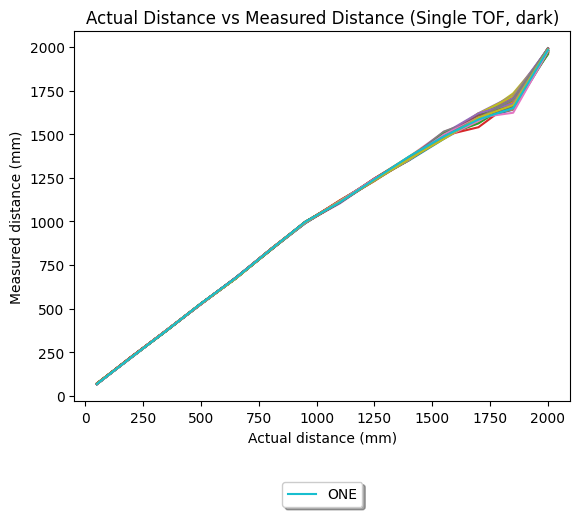

In [130]:
# Plot distance measurement data for two TOFs
actual = []
for i in range(50, 2150, 150):
    actual.append(i)
    
print(actual)
print(ONEdistanceAtLocation)
print(TWOdistanceAtLocation)

for set in range(49):
    plt.plot(actual, distanceAtLocation[:,set])
    
plt.plot(actual, distanceAtLocation[:,49], label = "ONE")

plt.title("Actual Distance vs Measured Distance (Single TOF, dark)")
plt.xlabel("Actual distance (mm)")
plt.ylabel("Measured distance (mm)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)


[50, 200, 350, 500, 650, 800, 950, 1100, 1250, 1400, 1550, 1700, 1850, 2000]
[[299. 302. 295. 299. 299. 296. 296. 298. 299. 296. 301. 300. 297. 300.
  302. 296. 299. 299. 299. 295. 296. 295. 305. 299. 300. 295. 304. 303.
  300. 300. 301. 299. 299. 296. 299. 299. 296. 303. 300. 298. 297. 301.
  297. 300. 299. 301. 296. 297. 297. 302.]
 [399. 400. 400. 399. 400. 401. 401. 400. 401. 400. 400. 399. 402. 398.
  400. 400. 400. 401. 399. 402. 401. 400. 399. 400. 402. 401. 401. 401.
  400. 400. 403. 399. 401. 399. 400. 403. 400. 402. 400. 399. 400. 402.
  401. 403. 402. 400. 401. 400. 401. 400.]
 [214. 217. 213. 215. 218. 215. 214. 214. 214. 216. 214. 215. 216. 216.
  216. 215. 218. 218. 216. 213. 217. 216. 214. 216. 217. 218. 215. 214.
  217. 216. 216. 217. 213. 220. 214. 218. 218. 214. 216. 217. 214. 216.
  214. 217. 213. 218. 216. 214. 216. 217.]
 [217. 218. 215. 217. 217. 217. 217. 217. 213. 215. 218. 217. 220. 218.
  216. 218. 218. 221. 216. 218. 220. 216. 216. 218. 219. 218. 217. 219.
  

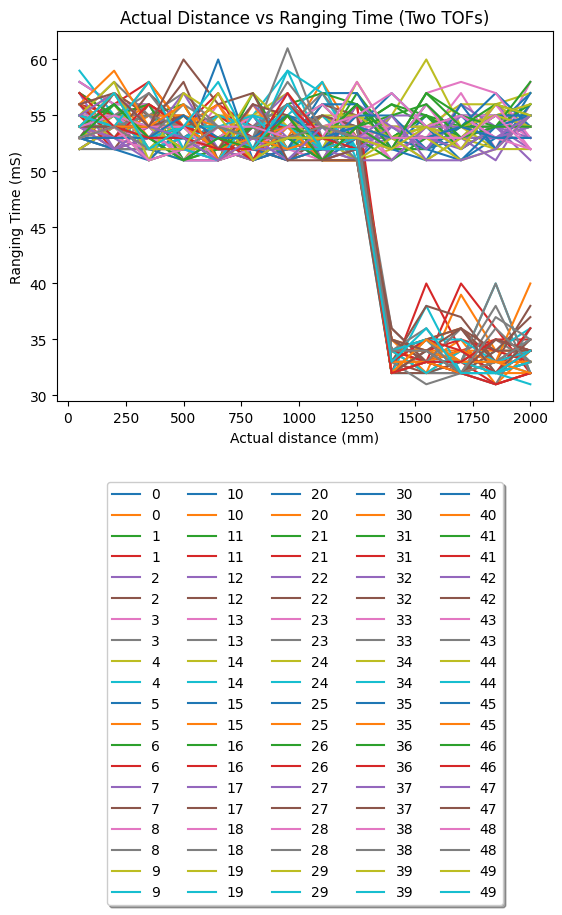

In [134]:
# Plot distance measurement data for two TOFs
actual = []
for i in range(50, 2150, 150):
    actual.append(i)
    
print(actual)
print(ONEdistanceAtLocation)
print(TWOdistanceAtLocation)

for set in range(49):
    plt.plot(actual, ONEtimeAtLocation[:,set], label = str(set))
    plt.plot(actual, TWOtimeAtLocation[:,set], label = str(set))
    
plt.plot(actual, ONEtimeAtLocation[:,49], label = str(49))
plt.plot(actual, TWOtimeAtLocation[:,49], label = str(49))

plt.title("Actual Distance vs Ranging Time (Two TOFs)")
plt.xlabel("Actual distance (mm)")
plt.ylabel("Ranging Time (mS)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)


In [9]:
ble.send_command(CMD.TIMED_TOF, "")

2023-02-16 05:00:47,594 | INFO     |: Disconnected from AB6C95E9-A4ED-4F7A-B208-0AFEAFDDA3AD


In [25]:
# Sensor readings against current time
def double_tof_callback(uuid, data):
    global ONEinstances
    global TWOinstances
    global location
    global ONEmillisAtLocation
    global ONEreadAtLocation
    global TWOmillisAtLocation
    global TWOreadAtLocation
    
    pair = (ble.bytearray_to_string(data)).split('|')
    
    if pair[2] == "1":
        ONEreadAtLocation.append(int(pair[0]))
        ONEmillisAtLocation.append(int(pair[1]))
    else:
        TWOreadAtLocation.append(int(pair[0]))
        TWOmillisAtLocation.append(int(pair[1]))
    
    # if (ONEinstances == 50 and TWOinstances == 49):


    print(ONEreadAtLocation)
    print(TWOreadAtLocation)

    print(ONEmillisAtLocation)
    print(TWOmillisAtLocation)
        # location += 1
        # ONEinstances = 0
        # TWOinstances = 0
    # else:
    #     if pair[2] == "1":
    #         ONEinstances += 1
    #     else:
    #         TWOinstances += 1

ONEmillisAtLocation =  []
ONEreadAtLocation =  []
TWOmillisAtLocation =  []
TWOreadAtLocation = []
location = 0
ONEinstances = 0
TWOinstances = 0
ble.start_notify(ble.uuid['RX_STRING'], double_tof_callback)
ble.send_command(CMD.TIMED_TOF, "")

[306]
[]
[29927]
[]
[306]
[577]
[29927]
[29939]
[306, 306]
[577]
[29927, 29986]
[29939]
[306, 306]
[577, 578]
[29927, 29986]
[29939, 30008]
[306, 306, 310]
[577, 578]
[29927, 29986, 30047]
[29939, 30008]
[306, 306, 310]
[577, 578, 575]
[29927, 29986, 30047]
[29939, 30008, 30071]
[306, 306, 310, 305]
[577, 578, 575]
[29927, 29986, 30047, 30109]
[29939, 30008, 30071]
[306, 306, 310, 305]
[577, 578, 575, 577]
[29927, 29986, 30047, 30109]
[29939, 30008, 30071, 30135]
[306, 306, 310, 305, 310]
[577, 578, 575, 577]
[29927, 29986, 30047, 30109, 30166]
[29939, 30008, 30071, 30135]
[306, 306, 310, 305, 310]
[577, 578, 575, 577, 576]
[29927, 29986, 30047, 30109, 30166]
[29939, 30008, 30071, 30135, 30197]
[306, 306, 310, 305, 310, 305]
[577, 578, 575, 577, 576]
[29927, 29986, 30047, 30109, 30166, 30233]
[29939, 30008, 30071, 30135, 30197]
[306, 306, 310, 305, 310, 305]
[577, 578, 575, 577, 576, 577]
[29927, 29986, 30047, 30109, 30166, 30233]
[29939, 30008, 30071, 30135, 30197, 30258]
[306, 306, 3

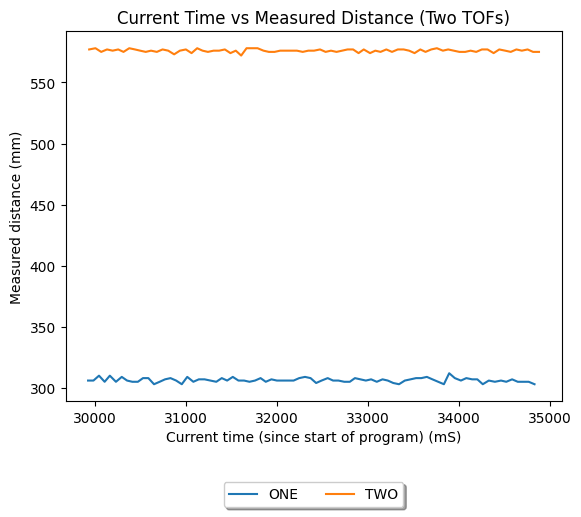

In [27]:
plt.plot(ONEmillisAtLocation, ONEreadAtLocation, label = "ONE")
plt.plot(TWOmillisAtLocation, TWOreadAtLocation, label = "TWO")

plt.title("Current Time vs Measured Distance (Two TOFs)")
plt.xlabel("Current time (since start of program) (mS)")
plt.ylabel("Measured distance (mm)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

In [28]:
%store ONEmillisAtLocation
%store ONEreadAtLocation
%store TWOmillisAtLocation
%store TWOreadAtLocation

Stored 'ONEmillisAtLocation' (list)
Stored 'ONEreadAtLocation' (list)
Stored 'TWOmillisAtLocation' (list)
Stored 'TWOreadAtLocation' (list)
2023-02-16 05:51:25,140 | INFO     |: Disconnected from AB6C95E9-A4ED-4F7A-B208-0AFEAFDDA3AD
